In [ ]:
!pip install mne

In [1]:
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pandas import read_csv
from datetime import datetime, timedelta
from pandas import read_json
import traceback
import math
from math import fabs, log 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories
from sklearn.svm import SVC
import pickle


In [2]:
print(__doc__)

data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
#print(conds.head(5))

max_trigger = 92
conds = conds[:max_trigger] 

Automatically created module for IPython interactive environment


In [3]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
#print(conditions[:10])


In [4]:
event_id = dict(zip(conditions, conds.trigger + 1))
#event_id['0/human bodypart/human/not-face/animal/natural']

In [5]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [6]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

2760 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2760 events and 601 original time points ...
2 bad epochs dropped


In [ ]:
# epochs['face'].average().plot()
# epochs['not-face'].average().plot()

In [7]:
X = epochs.copy().crop(0.095, 0.15).get_data()
y = epochs.events[:, 2]
classes = set(y)

In [10]:
classes = set(y)

In [ ]:
y_test.shape

In [8]:
scalers = {}
nFeatures = 1000
testSize = -826
np.random.seed(0)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]
X_train = X[:testSize]
X_test = X[testSize:]
y_train = y[:testSize]
y_test = y[testSize:]
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2] )
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2] )


In [13]:
# Run the PCA
pca = PCA(nFeatures)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
pickle.dump(pca, open("pca_%s"%nFeatures, "wb"))

ValueError: n_components=1000 must be between 0 and min(n_samples, n_features)=826 with svd_solver='full'

In [9]:
# Load the PCA
path = "C:/Users/lclea/Downloads" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = "C:/Users/lclea/Downloads/pca_1000"
loaded_pca = pickle.load(open(name, "rb"))
X_train = loaded_pca.transform(X_train)
X_test = loaded_pca.transform(X_test)

In [ ]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.

from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
clf = GridSearchCV(SVC(probability=True, gamma="auto"),
                       param_grid={'kernel':['linear', 'rbf', 'poly'], 'C':[1, 10],
                                   'probability': [True], 'degree': [5, 50, 500]},
                       cv=10,
                       n_jobs = -1,
                       refit=True)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [ ]:
# Save Model
path = "" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = ""
filename = path + name
pickle.dump(clf, open(name, "wb"))

In [28]:
# Load Model
path = "C:/Users/lclea/Downloads" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = "C:/Users/lclea/Downloads/2trees_together_1000"
loaded_model = pickle.load(open(name, "rb"))
y_predTest = loaded_model.predict_proba(X_test)
y_pred = loaded_model.predict(X_test)

In [29]:
np.array_equal(y_pred, y_predTest)

False

In [45]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y_test == train_class, y_predTest[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

In [ ]:
# get the matrix of the ROC values

In [30]:
auc_matrix = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        auc_matrix[ii, jj] = roc_auc_score(y_test == train_class, y_predTest[:, jj])
        auc_matrix[jj, ii] = auc_matrix[ii, jj]

In [32]:
print(auc_matrix[0,:])

[0.96581197 0.62201291 0.61678005 0.56619571 0.50811094 0.46938776
 0.63073435 0.54857841 0.68166754 0.53933368 0.53689168 0.58887145
 0.52468167 0.4460143  0.56811443 0.60962847 0.41217513 0.54334554
 0.48717949 0.41269841 0.50322693 0.4144427  0.52154195 0.48194662
 0.65515437 0.67469039 0.68131868 0.51997209 0.55590441 0.58119658
 0.60945404 0.4454038  0.53357753 0.57814408 0.42682714 0.65306122
 0.61451247 0.64843886 0.47078319 0.60509332 0.57910344 0.53741497
 0.67591139 0.67469039 0.53462411 0.69736613 0.65480551 0.64573522
 0.73931624 0.69562184 0.57823129 0.64276993 0.54317111 0.62358277
 0.42072214 0.62428048 0.60579103 0.56602128 0.51962323 0.29827316
 0.54683412 0.59549974 0.56392814 0.5600907  0.51020408 0.60282575
 0.44043258 0.49502878 0.58730159 0.37955695 0.65881737 0.54700855
 0.50776208 0.38374324 0.54962498 0.65306122 0.76207919 0.574045
 0.61782662 0.58869702 0.56026513 0.75684633 0.7238793  0.42926914
 0.61032618 0.73103087 0.74986918 0.59410431 0.47671376 0.715157

In [33]:
import csv

In [19]:
# get the upperTri for 92x92

df = pd.read_csv('C:/Users/lclea/Documents/machine_learning/Project/ssim_matrix.csv', skiprows=0)
upperTri_92 = np.triu(df)
# get the upperTri for each of the SOC's

ssim_HBP = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_HBP.csv', skiprows=0)
upperTri_HBP = np.triu(ssim_HBP)

ssim_HF = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_HF.csv', skiprows=0)
upperTri_HF = np.triu(ssim_HF)

ssim_NHBP = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_NHBP.csv', skiprows=0)
upperTri_NHBP = np.triu(ssim_NHBP)

ssim_NHF = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_NHF.csv', skiprows=0)
upperTri_NHF = np.triu(ssim_NHF)

ssim_NI = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_NI.csv', skiprows=0)
upperTri_NI = np.triu(ssim_NI)

ssim_AI = pd.read_csv('C:/Users/lclea/Documents/machine_learning/ssim_matrix_AI.csv', skiprows=0)
upperTri_AI = np.triu(ssim_AI)

print(upperTri_AI)

[[1.       0.36827  0.42915  0.13265  0.37417  0.19343  0.36276  0.29153
  0.35084  0.26041  0.24493  0.42914  0.3391   0.399    0.33968  0.34819
  0.29507  0.31618  0.43109  0.25155  0.15939 ]
 [0.       1.       0.56862  0.12543  0.37082  0.42305  0.55449  0.68627
  0.59657  0.22986  0.43722  0.62386  0.59774  0.48972  0.34818  0.54222
  0.43915  0.66949  0.3251   0.39265  0.30318 ]
 [0.       0.       1.       0.1914   0.41416  0.31999  0.57275  0.53358
  0.59097  0.29974  0.39114  0.66504  0.53009  0.55032  0.37966  0.5317
  0.47624  0.54068  0.39334  0.38594  0.2417  ]
 [0.       0.       0.       1.       0.17511  0.25176  0.16216  0.14477
  0.18201  0.020268 0.17077  0.20302  0.23671  0.18792  0.1373   0.2118
  0.15826  0.22368  0.1664   0.20608  0.05243 ]
 [0.       0.       0.       0.       1.       0.22545  0.37313  0.34569
  0.38718  0.21395  0.2827   0.43058  0.36532  0.39857  0.3318   0.42454
  0.31699  0.34743  0.39791  0.29732  0.18812 ]
 [0.       0.       0.       0. 

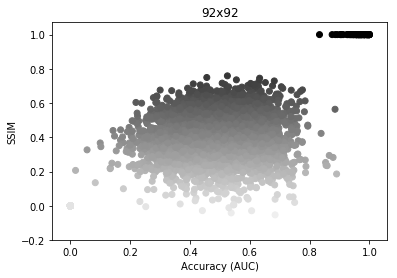

In [44]:
# plot 92x92 ssim vs AUC scores
upperTri_auc = np.triu(auc_matrix)

plt.scatter(upperTri_auc, upperTri_92, c=upperTri_92, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("92x92")

plt.show()

In [57]:
# get the upperTri AUC for each of the SOC's

# how? indexing the matrix for 92...


auc_matrix_HF = auc_matrix[0:12, 0:12]

auc_matrix_HBP = auc_matrix[12:24, 12:24]

auc_matrix_NHF = auc_matrix[24:36, 24:36]

auc_matrix_NHBP = auc_matrix[36:48, 36:48]

auc_matrix_NI = auc_matrix[48:71, 48:71]

auc_matrix_AI = auc_matrix[71:93, 71:93]



# print(auc_matrix)
# print("next")
# print(auc_matrix_HF)

# auc_matrix_HF = np.zeros((len(classes), len(classes)))
# for ii, train_class in enumerate(classes):
#     for jj in range(ii, len(classes)):
#         auc_matrix[ii, jj] = roc_auc_score(y_test == train_class, y_predTest[:, jj])
#         auc_matrix[jj, ii] = auc_matrix[ii, jj]


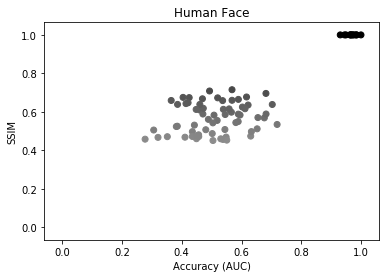

In [60]:
upperTri_HF_auc = np.triu(auc_matrix_HF)
plt.scatter(upperTri_HF_auc, upperTri_HF, c=upperTri_HF, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Human Face")
plt.show()

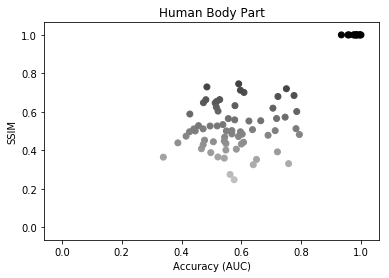

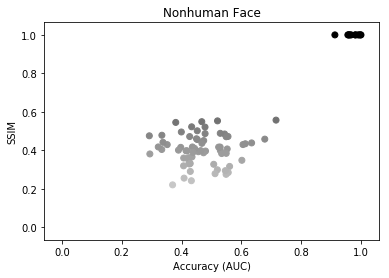

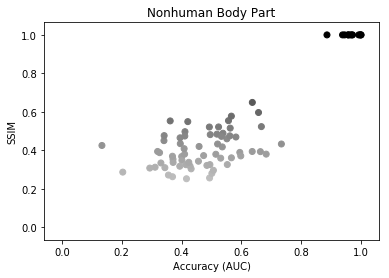

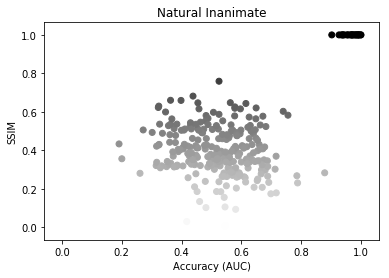

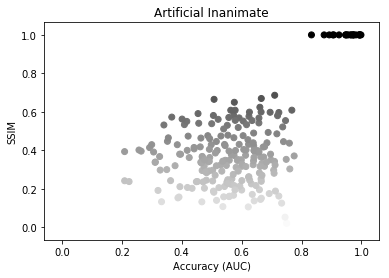

In [61]:
# plot the upperTri for each SOC vs the AUC value for that SOC
# upperTri_HF_auc = np.triu(auc_matrix_HF)
# plt.scatter(upperTri_HF_auc, upperTri_HF, c=upperTri_HF, cmap='binary')
# plt.xlabel("Accuracy (AUC)")
# plt.ylabel("SSIM")
# plt.title("Human Face")
# plt.show()

# etc...

upperTri_HBP_auc = np.triu(auc_matrix_HBP)
plt.scatter(upperTri_HBP_auc, upperTri_HBP, c=upperTri_HBP, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Human Body Part")
plt.show()

upperTri_NHF_auc = np.triu(auc_matrix_NHF)
plt.scatter(upperTri_NHF_auc, upperTri_NHF, c=upperTri_NHF, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Nonhuman Face")
plt.show()

upperTri_NHBP_auc = np.triu(auc_matrix_NHBP)
plt.scatter(upperTri_NHBP_auc, upperTri_NHBP, c=upperTri_NHBP, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Nonhuman Body Part")
plt.show()

upperTri_NI_auc = np.triu(auc_matrix_NI)
plt.scatter(upperTri_NI_auc, upperTri_NI, c=upperTri_NI, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Natural Inanimate")
plt.show()

upperTri_AI_auc = np.triu(auc_matrix_AI)
plt.scatter(upperTri_AI_auc, upperTri_AI, c=upperTri_AI, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Artificial Inanimate")
plt.show()


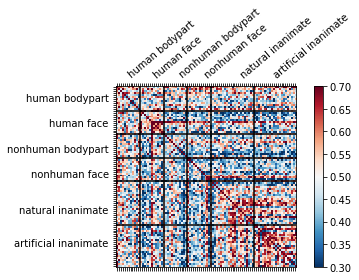

In [46]:
labels = ['']*5+['human bodypart']+['']*12+['human face']+['']*12+['nonhuman bodypart']+['']*12+['nonhuman face']+['']*17+['natural inanimate']+['']*16+['artificial inanimate']+['']*6

fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(12, color='k') ## human bodypart
ax.axhline(24, color='k') ## human face
ax.axhline(36, color='k') ## nonhuman bodypart
ax.axhline(48, color='k') ## nonhuman face
ax.axhline(70, color='k') ## natural inanimate
ax.axvline(12, color='k') ## human bodypart
ax.axvline(24, color='k') ## human face
ax.axvline(36, color='k') ## nonhuman bodypart
ax.axvline(48, color='k') ## nonhuman face
ax.axvline(70, color='k') ## natural inanimate
plt.colorbar(im)
plt.tight_layout()
plt.show()

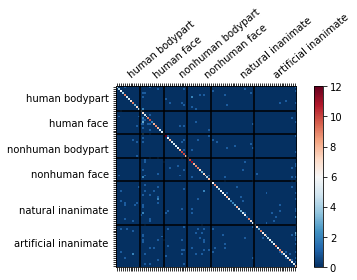

In [47]:
from sklearn.metrics import confusion_matrix
confusion2 = confusion_matrix(y_test, y_pred)

labels = ['']*5+['human bodypart']+['']*12+['human face']+['']*12+['nonhuman bodypart']+['']*12+['nonhuman face']+['']*17+['natural inanimate']+['']*16+['artificial inanimate']+['']*6

fig, ax = plt.subplots(1)
im = ax.matshow(confusion2, cmap='RdBu_r')
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(12, color='k') ## human bodypart
ax.axhline(24, color='k') ## human face
ax.axhline(36, color='k') ## nonhuman bodypart
ax.axhline(48, color='k') ## nonhuman face
ax.axhline(70, color='k') ## natural inanimate
ax.axvline(12, color='k') ## human bodypart
ax.axvline(24, color='k') ## human face
ax.axvline(36, color='k') ## nonhuman bodypart
ax.axvline(48, color='k') ## nonhuman face
ax.axvline(70, color='k') ## natural inanimate
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [48]:
for i in range(len(y_pred)):
    if 0<y_pred[i]<13:
        y_pred[i]=1
    elif 12<y_pred[i]<25:
        y_pred[i]=2
    elif 24<y_pred[i]<37:
        y_pred[i]=3
    elif 36<y_pred[i]<49:
        y_pred[i]=4
    elif 48<y_pred[i]<71:
        y_pred[i]=5
    elif 70<y_pred[i]<93:
        y_pred[i]=6
        
    if 0<y_test[i]<13:
        y_test[i]=1
    elif 12<y_test[i]<25:
        y_test[i]=2
    elif 24<y_test[i]<37:
        y_test[i]=3
    elif 36<y_test[i]<49:
        y_test[i]=4
    elif 48<y_test[i]<71:
        y_test[i]=5
    elif 70<y_test[i]<93:
        y_test[i]=6

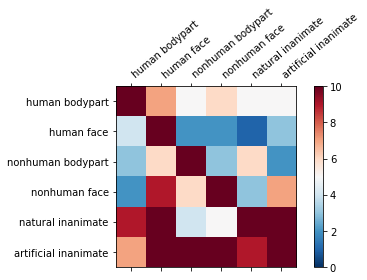

In [49]:
from sklearn.metrics import confusion_matrix
confusion3 = confusion_matrix(y_test, y_pred)

labels = ['human bodypart','human face','nonhuman bodypart','nonhuman face','natural inanimate','artificial inanimate']

fig, ax = plt.subplots(1)
im = ax.matshow(confusion3, cmap='RdBu_r', clim=[0, 10])
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=40, ha='left')
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
y_train.shape

In [ ]:
X_train.shape

In [12]:
# now do the same with AUC/SSIM plotting using the 3SVC

# Load Model
path = "C:/Users/lclea/Downloads" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = "C:/Users/lclea/Downloads/3svc_together"
loaded_model = pickle.load(open(name, "rb"))
y_predTest = loaded_model.predict_proba(X_test)
y_pred = loaded_model.predict(X_test)

In [22]:
# number of support vectors, clf (loaded_model is a gridsearchCV)

loaded_model.best_estimator_



VotingClassifier(estimators=[('linear', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=50, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('rbf', SVC(C=10, cache_size=200, class_weight=No...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 2, 1])

In [36]:
loaded_model.estimator.estimators[0][1]

AttributeError: 'SVC' object has no attribute 'support_vectors_'

In [16]:
loaded_model.best_params_

{'rbf__degree': 500,
 'rbf__C': 10,
 'poly__degree': 5,
 'poly__C': 10,
 'linear__degree': 50,
 'linear__C': 1}

In [18]:
loaded_model.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=VotingClassifier(estimators=[('linear', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('rbf', SVC(C=1.0, ca...e=False))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 2, 1]),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'linear__C': [1, 10], 'rbf__C': [1, 10], 'poly__C': [1, 10], 'linear__degree': [5, 50, 500], 'rbf__degree': [5, 50, 500], 'poly__degree': [5, 50, 500]},
          pre_dispatch='2*n_jobs', random_state=10, refit=True,
          return_train_score='warn', scoring=None, verbose=2)>

In [69]:
# get confusion AUC for this model

auc_matrix = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        auc_matrix[ii, jj] = roc_auc_score(y_test == train_class, y_predTest[:, jj])
        auc_matrix[jj, ii] = auc_matrix[ii, jj]

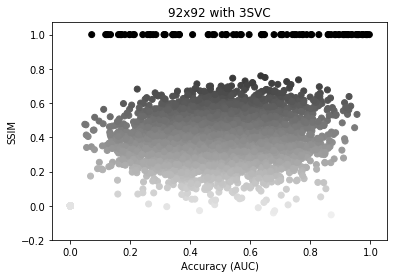

In [70]:
# plot 92x92 for auc ssim

upperTri_auc = np.triu(auc_matrix)

plt.scatter(upperTri_auc, upperTri_92, c=upperTri_92, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("92x92 with 3SVC")

plt.show()


In [71]:
# get auc for each SOC

auc_matrix_HF = auc_matrix[0:12, 0:12]

auc_matrix_HBP = auc_matrix[12:24, 12:24]

auc_matrix_NHF = auc_matrix[24:36, 24:36]

auc_matrix_NHBP = auc_matrix[36:48, 36:48]

auc_matrix_NI = auc_matrix[48:71, 48:71]

auc_matrix_AI = auc_matrix[71:93, 71:93]

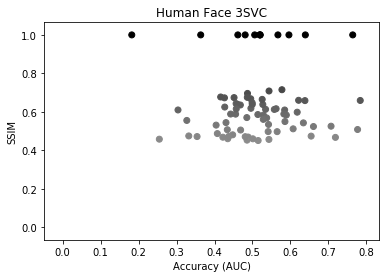

In [72]:
# let's test with one first

upperTri_HF_auc = np.triu(auc_matrix_HF)
plt.scatter(upperTri_HF_auc, upperTri_HF, c=upperTri_HF, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Human Face 3SVC")
plt.show()

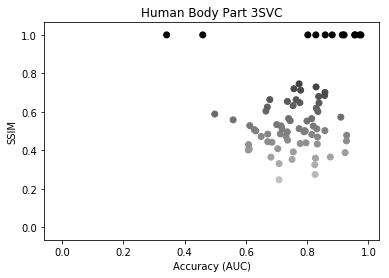

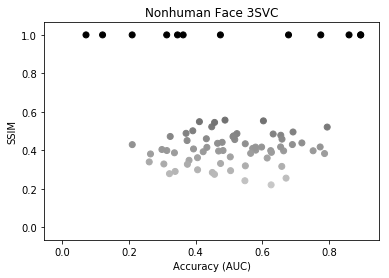

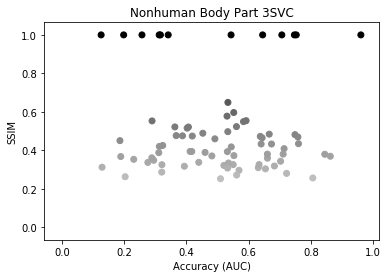

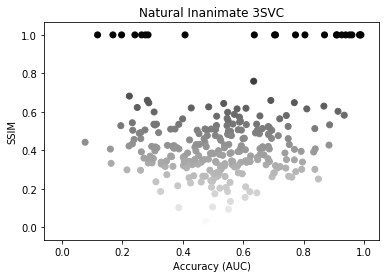

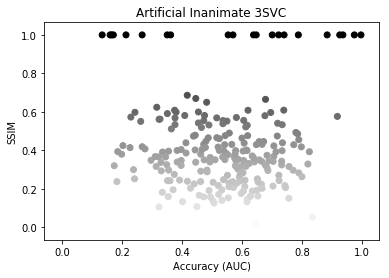

In [73]:
# now the rest:


upperTri_HBP_auc = np.triu(auc_matrix_HBP)
plt.scatter(upperTri_HBP_auc, upperTri_HBP, c=upperTri_HBP, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Human Body Part 3SVC")
plt.show()

upperTri_NHF_auc = np.triu(auc_matrix_NHF)
plt.scatter(upperTri_NHF_auc, upperTri_NHF, c=upperTri_NHF, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Nonhuman Face 3SVC")
plt.show()

upperTri_NHBP_auc = np.triu(auc_matrix_NHBP)
plt.scatter(upperTri_NHBP_auc, upperTri_NHBP, c=upperTri_NHBP, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Nonhuman Body Part 3SVC")
plt.show()

upperTri_NI_auc = np.triu(auc_matrix_NI)
plt.scatter(upperTri_NI_auc, upperTri_NI, c=upperTri_NI, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Natural Inanimate 3SVC")
plt.show()

upperTri_AI_auc = np.triu(auc_matrix_AI)
plt.scatter(upperTri_AI_auc, upperTri_AI, c=upperTri_AI, cmap='binary')
plt.xlabel("Accuracy (AUC)")
plt.ylabel("SSIM")
plt.title("Artificial Inanimate 3SVC")
plt.show()

In [ ]:
#esemble Methods 
#esemble Methods 

clf1 = SVC(probability=True, kernel="linear", gamma="auto")
clf2 = SVC(probability=True, kernel="rbf", gamma="auto")
clf3 = SVC(probability=True, kernel="poly", gamma="auto")

clf4 = VotingClassifier(estimators=[('linear', clf1), ('rbf', clf2), ('poly', clf3)], voting='soft', weights=[1, 2, 1])
                       
params = {'linear__C': [1,10], 'rbf__C': [1,10], 'poly__C': [1,10],'linear__degree': [5, 50, 500],'rbf__degree': [5, 50, 500],'poly__degree': [5, 50, 500] }
        
grid = RandomizedSearchCV(estimator=clf4,
                    cv=3,
                    param_distributions=params,
                    n_jobs = -1,
                    refit=True,
                    n_iter = 30, 
                    random_state=10,
                    verbose=2)
grid.fit(X_train, y_train)
y_pred = grid.predict_proba(X_test)
name = "3svc_together_%s"%nFeatures
#filename = path + name
pickle.dump(grid, open(name, "wb"))

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'gini__n_estimators': n_estimators,
               'gini__max_features': max_features,
               'gini__max_depth': max_depth,
               'gini__min_samples_split': min_samples_split,
               'gini__min_samples_leaf': min_samples_leaf,
               'gini__bootstrap': bootstrap,
               'entropy__n_estimators': n_estimators,
               'entropy__max_features': max_features,
               'entropy__max_depth': max_depth,
               'entropy__min_samples_split': min_samples_split,
               'entropy__min_samples_leaf': min_samples_leaf,
               'entropy__bootstrap': bootstrap,
              }


RFC1 = RandomForestClassifier(criterion = 'gini')
RFC2 = RandomForestClassifier(criterion = 'entropy')
RFC = VotingClassifier(estimators=[('gini', RFC1), ('entropy', RFC2)], voting='soft', weights=[1, 1])
RFC_RandomSearch = RandomizedSearchCV(estimator = RFC,
                                      param_distributions = random_grid,
                                      n_iter = 100, cv = 3, verbose=3,
                                      random_state=10, n_jobs = -1)

RFC_RandomSearch.fit(X_train, y_train)

y_pred = RFC_RandomSearch.predict_proba(X_test)
name = "2trees_together_%s"%nFeatures
#filename = path + name
pickle.dump(RFC_RandomSearch, open(name, "wb"))



In [ ]:
n_estimators = [int(x) for x in numpy.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in numpy.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'gini__n_estimators': n_estimators,
               'gini__max_features': max_features,
               'gini__max_depth': max_depth,
               'gini__min_samples_split': min_samples_split,
               'gini__min_samples_leaf': min_samples_leaf,
               'gini__bootstrap': bootstrap,
               'entropy__n_estimators': n_estimators,
               'entropy__max_features': max_features,
               'entropy__max_depth': max_depth,
               'entropy__min_samples_split': min_samples_split,
               'entropy__min_samples_leaf': min_samples_leaf,
               'entropy__bootstrap': bootstrap,
               'linear__C': [1,10], 
               'rbf__C': [1,10], 
               'poly__C': [1,10],
               'linear__degree': [5, 50, 500],
               'rbf__degree': [5, 50, 500],
               'poly__degree': [5, 50, 500] 
              }


RFC1 = RandomForestClassifier(criterion = 'gini')
RFC2 = RandomForestClassifier(criterion = 'entropy')
clf1 = SVC(probability=True, kernel="linear", gamma="auto")
clf2 = SVC(probability=True, kernel="rbf", gamma="auto")
clf3 = SVC(probability=True, kernel="poly", gamma="auto")
vote = VotingClassifier(estimators=[('linear', clf1), ('rbf', clf2), ('poly', clf3), ('gini', RFC1), ('entropy', RFC2)], voting='soft', weights=[1, 2, 1, 1, 1])

RandomSearch = RandomizedSearchCV(estimator = vote,
                                      param_distributions = random_grid,
                                      n_iter = 100, cv = 3, verbose=3,
                                      random_state=10, n_jobs = -1)

RandomSearch.fit(X_train, y_train)

y_pred = RandomSearch.predict_proba(X_test)
name = "5models_%s"%nFeatures
#filename = path + name
pickle.dump(RandomSearch, open(name, "wb"))


In [ ]:
!git add *
!git commit -m "adding models with 1000 features"
!git push

In [ ]:
# Code for one hot encoding if needed
numCats = 92
numTrials = X.shape[0]

oneHotY = np.zeros((numTrials, numCats))
for i in range(numTrials):
    oneHotY[i][y[i]-1] = 1
